<a href="https://colab.research.google.com/github/Shams200648/CSE366Lab/blob/main/AI_Lab_05a_Pretrained_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rifat963/pumpkin")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/rifat963/pumpkin/versions/2


In [53]:
import shutil

src = '/root/.cache/kagglehub/datasets/rifat963/pumpkin/versions/2'
dst = '/content'

shutil.copytree(src, dst, dirs_exist_ok=True)

'/content'

In [54]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models


from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
import itertools


In [55]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])): # itertools is now accessible
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [56]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Data transforms for training and validation

In [57]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
}

In [58]:
data_dir = '/content/Augmented/Augmented'  # Update this with your local path
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [59]:
# List of pretrained models to experiment with
pretrained_models = {
    'resnet18': models.resnet18(pretrained=True),
    'densenet161': models.densenet161(pretrained=True),
    # 'inception_v3': models.inception_v3(pretrained=True),
    'mobilenet_v3_small': models.mobilenet_v3_small(pretrained=True)
}

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-dat

In [60]:
num_classes = len(class_names)
print(f"Number of classes:{num_classes}")
num_epochs = 2  # Adjust as needed

Number of classes:5


In [61]:
def train_and_evaluate_model(model, model_name):
    # Modify final layer according to the architecture
    if model_name.startswith('resnet'):
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif 'densenet' in model_name:
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)
    elif 'inception' in model_name:
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif 'mobilenet' in model_name:
        num_ftrs = model.classifier[3].in_features
        model.classifier[3] = nn.Linear(num_ftrs, num_classes)

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    print(f"\nTraining model: {model_name}")

    # Training loop
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    # After training, evaluate on the validation set:
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []  # to store probabilities for ROC curve

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probabilities.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Classification report and confusion matrix
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    print("Confusion Matrix:")
    cm = confusion_matrix(all_labels, all_preds) # Assign the confusion matrix to cm

    plot_confusion_matrix(cm, classes=class_names, title=f'Confusion Matrix for {model_name}')

    # ROC curve for each class (One-vs-Rest)
    fpr = {}
    tpr = {}
    roc_auc = {}
    labels_binarized = label_binarize(all_labels, classes=range(num_classes))

    plt.figure()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_binarized[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i],
                 label=f'ROC curve for {class_names[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random chance
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for {model_name}')
    plt.legend(loc="lower right")
    plt.show()



Training model: resnet18
Epoch 1/2
Train Loss: 0.7933 Acc: 0.7060
Val Loss: 0.5566 Acc: 0.7970
Epoch 2/2
Train Loss: 0.4770 Acc: 0.8250
Val Loss: 0.5158 Acc: 0.8296

Classification Report:
                     precision    recall  f1-score   support

Bacterial Leaf Spot       0.73      0.76      0.75        76
       Downy Mildew       0.80      0.91      0.85        79
       Healthy Leaf       0.86      0.89      0.87        80
     Mosaic Disease       0.90      0.97      0.93        72
     Powdery_Mildew       0.87      0.65      0.75        92

           accuracy                           0.83       399
          macro avg       0.83      0.84      0.83       399
       weighted avg       0.83      0.83      0.83       399

Confusion Matrix:
Confusion matrix, without normalization
[[58  4  9  1  4]
 [ 1 72  0  1  5]
 [ 9  0 71  0  0]
 [ 0  2  0 70  0]
 [11 12  3  6 60]]


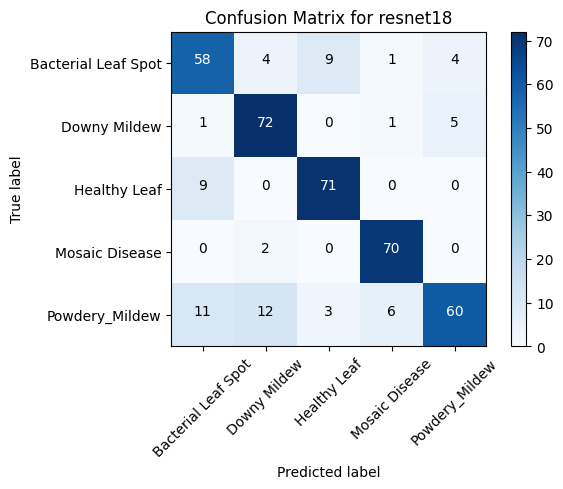

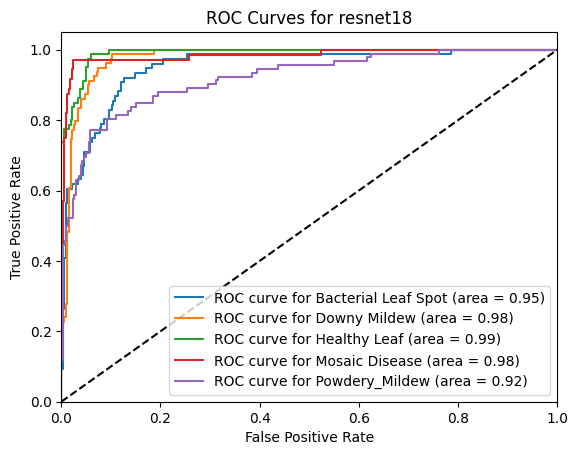


Training model: densenet161
Epoch 1/2


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 0.7402 Acc: 0.7431
Val Loss: 0.5207 Acc: 0.8070
Epoch 2/2
Train Loss: 0.4142 Acc: 0.8486
Val Loss: 0.4840 Acc: 0.8346

Classification Report:
                     precision    recall  f1-score   support

Bacterial Leaf Spot       0.73      0.80      0.77        76
       Downy Mildew       0.82      0.91      0.86        79
       Healthy Leaf       0.83      0.90      0.86        80
     Mosaic Disease       0.92      0.96      0.94        72
     Powdery_Mildew       0.89      0.64      0.75        92

           accuracy                           0.83       399
          macro avg       0.84      0.84      0.84       399
       weighted avg       0.84      0.83      0.83       399

Confusion Matrix:
Confusion matrix, without normalization
[[61  2 11  0  2]
 [ 2 72  0  1  4]
 [ 8  0 72  0  0]
 [ 0  2  0 69  1]
 [12 12  4  5 59]]


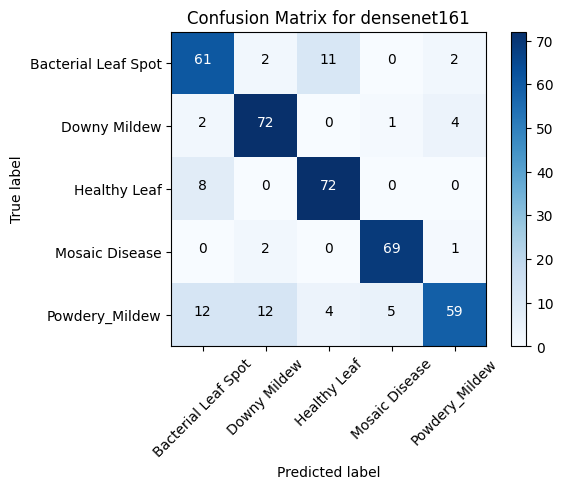

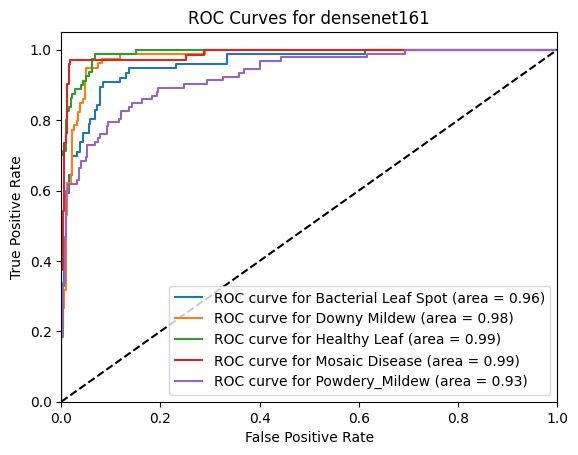


Training model: mobilenet_v3_small
Epoch 1/2


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.0446 Acc: 0.6393
Val Loss: 0.7695 Acc: 0.7393
Epoch 2/2
Train Loss: 0.5964 Acc: 0.7864
Val Loss: 0.6486 Acc: 0.7820

Classification Report:
                     precision    recall  f1-score   support

Bacterial Leaf Spot       0.63      0.74      0.68        76
       Downy Mildew       0.80      0.86      0.83        79
       Healthy Leaf       0.80      0.94      0.86        80
     Mosaic Disease       0.86      0.93      0.89        72
     Powdery_Mildew       0.87      0.50      0.63        92

           accuracy                           0.78       399
          macro avg       0.79      0.79      0.78       399
       weighted avg       0.79      0.78      0.77       399

Confusion Matrix:
Confusion matrix, without normalization
[[56  3 14  0  3]
 [ 3 68  0  4  4]
 [ 5  0 75  0  0]
 [ 0  5  0 67  0]
 [25  9  5  7 46]]


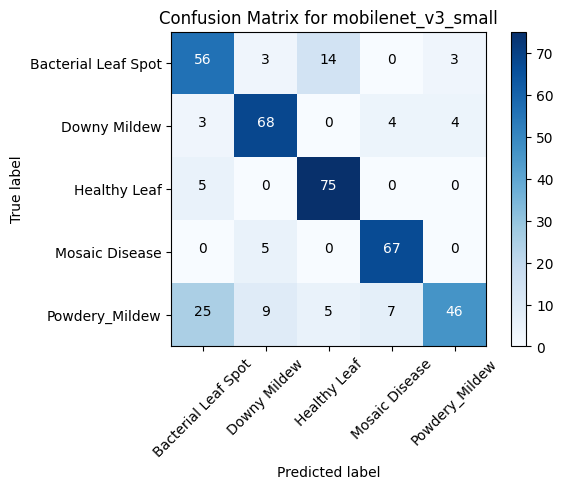

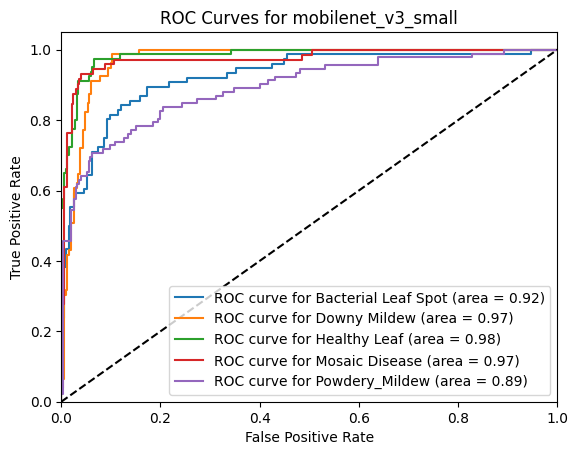

In [62]:
# Loop through each pretrained model, train and evaluate
for name, model in pretrained_models.items():
    train_and_evaluate_model(model, name)

# Data transforms for training and validation

In [63]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.299, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.299, 0.225])
    ]),
}

In [64]:
data_dir = '/content/Augmented/Augmented'  # Update this with your local path
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [69]:
# List of pretrained models to experiment with
pretrained_models = {
    # 'resnet18': models.resnet18(pretrained=True),
    # 'densenet161': models.densenet161(pretrained=True),
    'inception_v3': models.inception_v3(pretrained=True),
    # 'mobilenet_v3_small': models.mobilenet_v3_small(pretrained=True)
}

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [70]:
num_classes = len(class_names)
print(f"Number of classes:{num_classes}")
num_epochs = 2  # Adjust as needed

Number of classes:5


In [75]:
def train_and_evaluate_model(model, model_name):
    # Modify final layer according to the architecture
    if model_name.startswith('resnet'):
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif 'densenet' in model_name:
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)
    elif 'inception' in model_name:
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif 'mobilenet' in model_name:
        num_ftrs = model.classifier[3].in_features
        model.classifier[3] = nn.Linear(num_ftrs, num_classes)

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    print(f"\nTraining model: {model_name}")

    # Training loop
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)

                    # Get logits from InceptionOutputs for loss calculation
                    if isinstance(outputs, models.inception.InceptionOutputs):
                        outputs = outputs.logits

                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    # After training, evaluate on the validation set:
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []  # to store probabilities for ROC curve

    with torch.no_grad(): # Fixed indentation here
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Get logits from InceptionOutputs for probability calculation
            if isinstance(outputs, models.inception.InceptionOutputs):
                outputs = outputs.logits

            probabilities = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probabilities.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Classification report and confusion matrix
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    print("Confusion Matrix:")
    cm = confusion_matrix(all_labels, all_preds)  # Assign the confusion matrix to cm

    plot_confusion_matrix(cm, classes=class_names, title=f'Confusion Matrix for {model_name}')

    # ROC curve for each class (One-vs-Rest)
    fpr = {}
    tpr = {}
    roc_auc = {}
    labels_binarized = label_binarize(all_labels, classes=range(num_classes))

    plt.figure()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_binarized[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i],
                 label=f'ROC curve for {class_names[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random chance
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for {model_name}')
    plt.legend(loc="lower right")
    plt.show()


Training model: inception_v3
Epoch 1/2


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.0336 Acc: 0.6243
Val Loss: 0.5787 Acc: 0.7995
Epoch 2/2
Train Loss: 0.5323 Acc: 0.8148
Val Loss: 0.5555 Acc: 0.7970

Classification Report:
                     precision    recall  f1-score   support

Bacterial Leaf Spot       0.67      0.84      0.74        76
       Downy Mildew       0.77      0.89      0.82        79
       Healthy Leaf       0.87      0.86      0.87        80
     Mosaic Disease       0.93      0.78      0.85        72
     Powdery_Mildew       0.81      0.64      0.72        92

           accuracy                           0.80       399
          macro avg       0.81      0.80      0.80       399
       weighted avg       0.81      0.80      0.80       399

Confusion Matrix:
Confusion matrix, without normalization
[[64  4  6  0  2]
 [ 4 70  0  1  4]
 [11  0 69  0  0]
 [ 1  6  1 56  8]
 [16 11  3  3 59]]


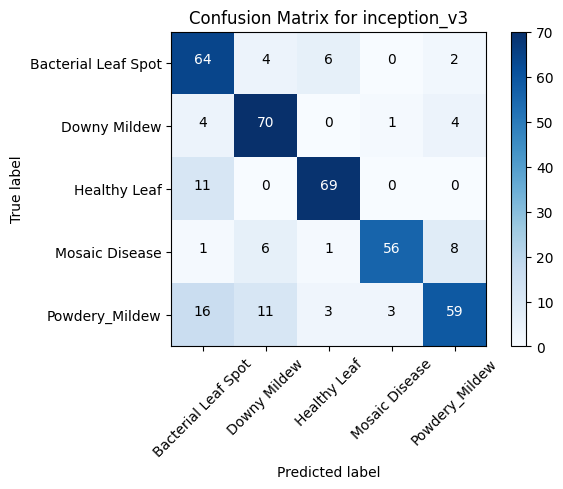

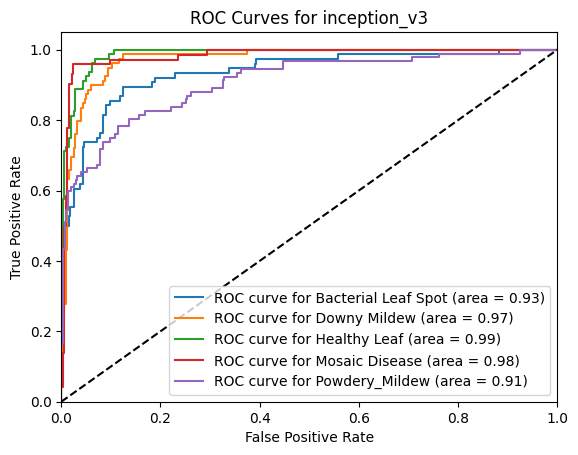

In [76]:
# Loop through each pretrained model, train and evaluate
for name, model in pretrained_models.items():
    train_and_evaluate_model(model, name)

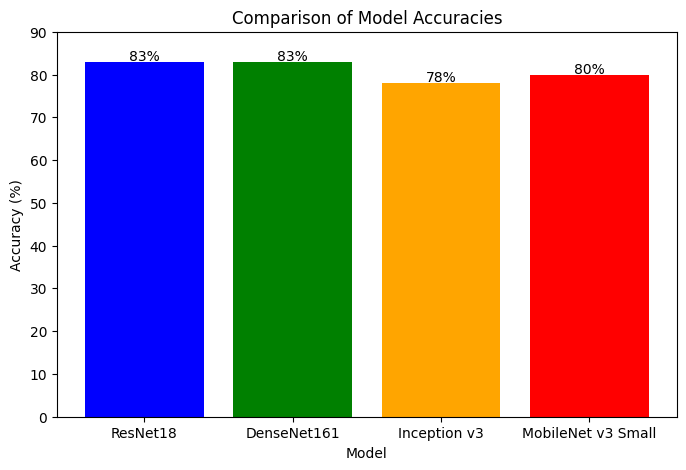

In [79]:
import matplotlib.pyplot as plt

# Sample accuracy values (Replace these with actual results after training)
model_names = ['ResNet18', 'DenseNet161', 'Inception v3', 'MobileNet v3 Small']
accuracies = [83, 83, 78, 80]  # Example accuracy percentages

# Create bar plot
plt.figure(figsize=(8, 5))
plt.bar(model_names, accuracies, color=['blue', 'green', 'orange', 'red'])

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Model Accuracies')
plt.ylim(0, 90)  # Adjust based on accuracy range

# Display values on top of bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.3, f'{acc}%', ha='center', fontsize=10)

# Show plot
plt.show()
